# Rule-Based Crypto Trading Strategy with Candlestick Pattern Detection and Backtesting

This project implements a complete, rule-based crypto trading strategy pipeline using Python. It fetches real-time and historical candlestick (OHLCV) data for Bitcoin via the cybotrade_datasource API, detects classical candlestick reversal patterns (Engulfing and Star formations), and filters trade signals based on support and resistance levels. These signals are then backtested using the backtesting library to evaluate the performance of the strategy over time.

By combining traditional technical analysis with programmable trading logic, the system enables efficient signal generation and performance evaluation — offering a foundation for further development into algorithmic or machine learning-based strategies.

### Assumption
Market Behavior Reflects Historical Patterns
The crypto market exhibits recurring candlestick patterns (like engulfing and star formations) that can signal future price movements.

High-Frequency Data is Reliable
One-minute candle data is assumed to be accurate and detailed enough for detecting valid trading signals.

Signal-Based Strategies Can Outperform Random Entries
By only acting on signals that match strict pattern and proximity criteria, the strategy aims to reduce noise and avoid random, unprofitable trades.

### Hypothesis
H1: Candle Pattern Signals Predict Short-Term Reversals

H2: Filtered Signals Improve Strategy Performance

In [ ]:
!pip install cybotrade_datasource
!pip install python-dotenv

import pandas as pd
import numpy as np
import asyncio
import cybotrade_datasource
from datetime import datetime, timezone
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


import warnings as wr
wr.filterwarnings('ignore')

print(dir(cybotrade_datasource))

load_dotenv()

API_KEY = os.getenv('CYBOTRADE_API_KEY')


global_df = None 

async def get_data(topic):
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic=topic, 
        limit=10000
    )
    return pd.DataFrame(data)


async def main():
    global global_df

    topics = [
        "bybit-linear|candle?symbol=BTCUSDT&interval=1m",
    ]

#topic
#"cryptoquant|btc/market-data/open-interest?exchange=bybit&window=min",
#bybit-linear|candle?interval=1m&symbol=BTCUSDT
#"cryptoquant|btc/market-data/coinbase-premium-index?window=hour",
#"cryptoquant|btc/exchange-flows/outflow?exchange=coinbase_advanced&window=hour",
#"glassnode|market/deltacap_usd?a=BTC&i=10m",

    tasks = [get_data(topic) for topic in topics]
    dataframes = await asyncio.gather(*tasks)

    for i, df in enumerate(dataframes):
        print(f"DataFrame {i+1} ({topics[i]})")
        print(df.head)
        print(df.isnull().sum())
        global_df = df

await main()


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'cybotrade_datasource', 'query', 'query_paginated', 'stream']
DataFrame 1 (bybit-linear|candle?symbol=BTCUSDT&interval=1m)
<bound method NDFrame.head of          start_time    close     high      low     open  volume
0     1743737940000  82716.6  82716.6  82680.7  82699.1  21.564
1     1743738000000  82681.3  82716.6  82680.9  82716.6  20.615
2     1743738060000  82701.5  82701.5  82681.3  82681.3  25.504
3     1743738120000  82693.3  82706.3  82692.6  82701.5  24.355
4     1743738180000  82707.8  82707.9  82693.2  82693.3   7.421
...             ...      ...      ...      ...      ...     ...
9995  1744337640000  80260.1  80275.7  80196.6  80196.6  17.981
9996  1744337700000  80280.5  80299.0  80249.5  80260.1  28.817
9997  1744337760000  80190.7  80283.9  80190.0  80280.5  24.558
9998  1744337820000  80232.1  80244.9  80190.7  80190.7  23.115
9999  1744337880000  802

In [2]:
global_df['start_time'] = pd.to_datetime(global_df['start_time'], unit='ms')


print(global_df[['start_time']])

              start_time
0    2025-04-04 03:39:00
1    2025-04-04 03:40:00
2    2025-04-04 03:41:00
3    2025-04-04 03:42:00
4    2025-04-04 03:43:00
...                  ...
9995 2025-04-11 02:14:00
9996 2025-04-11 02:15:00
9997 2025-04-11 02:16:00
9998 2025-04-11 02:17:00
9999 2025-04-11 02:18:00

[10000 rows x 1 columns]


In [3]:
def support(df1, l, n1, n2):
    for i in range(l - n1 + 1, l + 1):
        if df1.low[i] < df1.low[i - 1]:
            return 0
    for i in range(l + 1, l + n2 + 1):
        if df1.low[i] < df1.low[i - 1]:
            return 0
    return 1

def resistance(df1, l, n1, n2):
    for i in range(l - n1 + 1, l + 1):
        if df1.high[i] < df1.high[i - 1]:
            return 0
    for i in range(l + 1, l + n2 + 1):
        if df1.high[i] < df1.high[i - 1]:
            return 0
    return 1

length = len(global_df)
high = list(global_df['high'])
low = list(global_df['low'])
close = list(global_df['close'])
open_ = list(global_df['open'])  # `open` is a built-in function in Python
bodydiff = [0] * length
highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(row):
    bodydiffmin = 0.002
    bodydiff[row] = abs(open_[row] - close[row])
    if bodydiff[row] < 0.000001:
        bodydiff[row] = 0.000001

    if (bodydiff[row] > bodydiffmin and bodydiff[row - 1] > bodydiffmin and
        open_[row - 1] < close[row - 1] and
        open_[row] > close[row] and
        (open_[row] - close[row - 1]) >= -5e-5 and close[row] < open_[row - 1]):
        return 1  # Bearish Engulfing
    elif (bodydiff[row] > bodydiffmin and bodydiff[row - 1] > bodydiffmin and
          open_[row - 1] > close[row - 1] and
          open_[row] < close[row] and
          (open_[row] - close[row - 1]) <= 5e-5 and close[row] > open_[row - 1]):
        return 2  # Bullish Engulfing
    else:
        return 0

def isStar(row):
    bodydiffmin = 0.002
    bodydiff[row] = abs(open_[row] - close[row])
    if bodydiff[row] < 0.000001:
        bodydiff[row] = 0.000001

    highdiff[row] = high[row] - max(open_[row], close[row])
    lowdiff[row] = min(open_[row], close[row]) - low[row]

    ratio1[row] = highdiff[row] / bodydiff[row]
    ratio2[row] = lowdiff[row] / bodydiff[row]

    if ratio1[row] > 1 and lowdiff[row] < 0.2 * highdiff[row] and bodydiff[row] > bodydiffmin:
        return 1  # Shooting star (bearish)
    elif ratio2[row] > 1 and highdiff[row] < 0.2 * lowdiff[row] and bodydiff[row] > bodydiffmin:
        return 2  # Inverted hammer (bullish)
    else:
        return 0

def closeSupport(row, support_levels, threshold):
    current_price = global_df.close[row]
    return any(abs(current_price - level) / current_price < threshold for level in support_levels)

def closeResistance(row, resistance_levels, threshold):
    current_price = global_df.close[row]
    return any(abs(current_price - level) / current_price < threshold for level in resistance_levels)

n1 = 2
n2 = 2
backCandles = 45
signal = [0] * length

for row in range(backCandles + n1, length - n2):
    ss = []
    rr = []

    for subrow in range(row - backCandles + n1, row + 1):
        if support(global_df, subrow, n1, n2):
            ss.append(global_df.low[subrow])
        if resistance(global_df, subrow, n1, n2):
            rr.append(global_df.high[subrow])

    eng = isEngulfing(row)
    star = isStar(row)

    if (eng == 1 or star == 1) and closeResistance(row, rr, 0.0015):
        signal[row] = 1  # Sell signal
    elif (eng == 2 or star == 2) and closeSupport(row, ss, 0.0015):
        signal[row] = 2  # Buy signal
    else:
        signal[row] = 0



global_df['signal'] = signal

In [4]:
global_df[global_df['signal']==1].count()

start_time    1212
close         1212
high          1212
low           1212
open          1212
volume        1212
signal        1212
dtype: int64

Count how many signal that i get.

In [5]:
global_df.columns = ['start_time', 'close', 'high','low','open','volume','signal']
global_df.tail()

,start_time,close,high,low,open,volume,signal
9995,2025-04-11 02:14:00,80260.1,80275.7,80196.6,80196.6,17.981,0
9996,2025-04-11 02:15:00,80280.5,80299.0,80249.5,80260.1,28.817,0
9997,2025-04-11 02:16:00,80190.7,80283.9,80190.0,80280.5,24.558,1
9998,2025-04-11 02:17:00,80232.1,80244.9,80190.7,80190.7,23.115,0
9999,2025-04-11 02:18:00,80267.6,80300.0,80232.1,80232.1,54.445,0


In [6]:
def SIGNAL():
    return global_df.signal
    


Define strategy and backtesting

In [7]:
!pip install backtesting
from backtesting import Strategy

class MyCandleStrat(Strategy):
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        if self.signal1 == 2:
            sl1 = self.data.Close[-1] - 750e-4
            tp1 = self.data.Close[-1] + 600e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 750e-4
            tp1 = self.data.Close[-1] - 600e-4
            self.sell(sl=sl1, tp=tp1)



    

Loading BokehJS ...

In [8]:
print(global_df['signal'].value_counts())

signal
0    7581
1    1212
2    1207
Name: count, dtype: int64


In [9]:
# Ensure columns are named correctly
global_df = global_df.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close'
})

In [10]:
from backtesting import Backtest

bt = Backtest(global_df, MyCandleStrat, cash=10_000, commission=0.002)
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/9999 [00:00<?, ?bar/s]

Start                                     0.0
End                                    9999.0
Duration                               9999.0
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                -2.96071
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Alpha [%]                                 0.0
Beta                                      0.0
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                  0.0
Win Rate [%]                              NaN
Best Trade [%]                    

In [11]:
bt.plot()

GridPlot(id='p1128', ...)

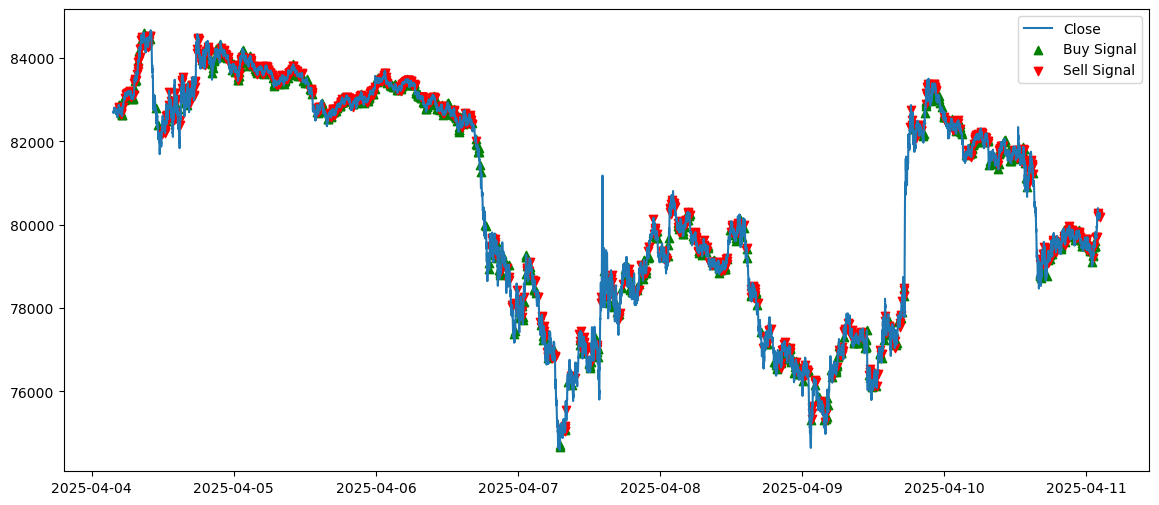

In [12]:
plt.figure(figsize=(14,6))
plt.plot(global_df['start_time'], global_df['Close'], label='Close')

buy_signals = global_df[global_df['signal'] == 2]
sell_signals = global_df[global_df['signal'] == 1]

plt.scatter(buy_signals['start_time'], buy_signals['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(sell_signals['start_time'], sell_signals['Close'], marker='v', color='red', label='Sell Signal')
plt.legend()
plt.show()